In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
# from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rdkit import Chem

In [3]:
## To avoid using up submissions, we create our own test set out of the training data.  This allows us to experiment
##    wildly and estimate error on various models.  

In [4]:
from harness import RMSE, train_test, write_to_file
xtrain, xtest, ytrain, ytest=train_test()

Loading Training Data...
Splitting Data...


In [5]:
xtest.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
276826,[nH]1cccc1-c1ccc(cn1)-c1sc(-c2nccs2)c2cc[nH]c12,0,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
849425,c1sc(-c2ccc(cc2)-c2sc(-c3cccc4c[nH]cc34)c3[se]...,0,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
504499,c1sc(-c2cc3[se]c4c(oc5ccc6cscc6c45)c3cn2)c2cc[...,0,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
601054,[nH]1c2C=C[SiH2]c2c2[nH]c3cc([se]c3c12)-c1cccc...,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
980221,[nH]1c(cc2c3cocc3c3c4ccccc4sc3c12)-c1cccc2cocc12,0,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
xtest_smiles = xtest['smiles']
xtest = xtest.drop(['smiles'], axis=1)
xtrain_smiles = xtrain['smiles']
xtrain = xtrain.drop(['smiles'], axis=1)

In [7]:
"""
Example Feature Engineering

this calculates the length of each smile string and adds a feature column with those lengths
Note: this is NOT a good feature and will result in a lower score!
"""
#smiles_len = np.vstack(df_all.smiles.astype(str).apply(lambda x: len(x)))
#df_all['smiles_len'] = pd.DataFrame(smiles_len)


'\nExample Feature Engineering\n\nthis calculates the length of each smile string and adds a feature column with those lengths\nNote: this is NOT a good feature and will result in a lower score!\n'

In [12]:
%%time
LR1 = LinearRegression()
LR1.fit(xtrain, ytrain)
# Prediction of LR on our test set
LR_pred1 = LR1.predict(xtest)

CPU times: user 11.9 s, sys: 2.85 s, total: 14.7 s
Wall time: 11.4 s


In [13]:
rmse1 = RMSE(LR_pred1, ytest)

RMSE =  0.298502133902


In [14]:
%%time
RF1 = RandomForestRegressor()
RF1.fit(xtrain, ytrain)
# Prediction of RF on the training set
RF_pred1 = RF1.predict(xtest)

CPU times: user 30.8 s, sys: 844 ms, total: 31.6 s
Wall time: 31.7 s


In [15]:
rmse2 = RMSE(RF_pred1, ytest)

RMSE =  0.271381164183


In [ ]:
## In the provided code, the RF predictor performs better than LR on the training set, but the 
##     LR predictor performs better than RF on the actual uploaded test set.  

In [25]:
## We will use these error values as baselines for our model tweaks.
def LRimprovement(prediction, test=ytest):
    imp = rmse1 - RMSE(prediction, test)
    print "Improvement on original Linear Regression: ", imp
    return imp

def RFimprovement(prediction, test=ytest):
    imp = rmse2 - RMSE(prediction, test)
    print "Improvement on original Random Forest: ", imp
    return imp

In [ ]:
## To beat the baseline, we will want to do some exploratory analysis to get some intuition on the features.  

In [37]:
print "Maximum gap in training set: ", np.max(ytrain)
print "Maximum gap in test set:     ", np.max(ytest)
print "Minimum gap in training set: ", np.min(ytrain)
print "Minimum gap in test set:     ", np.min(ytest)

Maximum gap in training set:  3.8
Maximum gap in test set:      3.43
Minimum gap in training set:  -1.44
Minimum gap in test set:      0.75


In [ ]:
## Notice the anomalous value in the training set.  Let's look at the distribution of gap values in each set.  

(-2, 4)

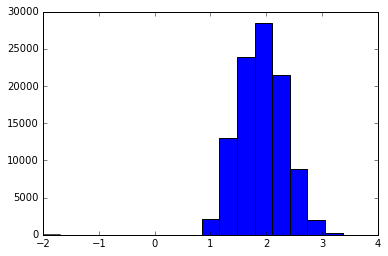

In [53]:
plt.hist(ytest, bins=np.linspace(-2,4,20))
plt.xlim([-2,4])

(-2, 4)

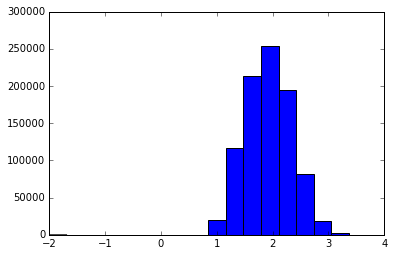

In [54]:
plt.hist(ytrain, bins=np.linspace(-2,4,20))
plt.xlim([-2,4])

In [55]:
## The distributions are the same shape, but there are three values in the test set that are clearly erroneous:
np.sum(ytrain<0)

3

In [17]:
## Let's drop those three rows out, because they can't be helping our models:
xtrain = xtrain[ytrain>0]
ytrain = ytrain[ytrain>0]

In [27]:
%%time
LR = LinearRegression()
LR.fit(xtrain, ytrain)
# Prediction of LR on our test set
LR_pred = LR.predict(xtest)
LRimprovement(LR_pred)
# RMSE(LR_pred, ytest)

RMSE =  0.298501403843
Improvement on original Linear Regression:  7.30058257015e-07
CPU times: user 13.4 s, sys: 3.73 s, total: 17.1 s
Wall time: 13.9 s


In [28]:
%%time
RF = RandomForestRegressor()
RF.fit(xtrain, ytrain)
# Prediction of RF on the training set
RF_pred = RF.predict(xtest)
RFimprovement(RF_pred)
# RMSE(RF_pred, ytest)

RMSE =  0.271364949307
Improvement on original Random Forest:  1.62148765907e-05
CPU times: user 30.7 s, sys: 767 ms, total: 31.5 s
Wall time: 31.3 s


In [ ]:
## This didn't make much difference, but there is no reason to keep the rows with implausible gap values in our 
#      training set, so we will stick with this.  

## Next, let's take a look at the features themselves.  


In [32]:
train_descrip = xtrain.describe()
## Notice that some features have 0 values for all observations.  These columns contain no information, so perhaps
##     we should remove these from the model.  We could remove these columns from the training set, train the model, 
##     then remove the same columns from the test set before making the predictions.  
train_descrip

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
count,899997.000000,899997,899997,899997,899997.000000,899997.000000,899997.000000,899997,899997,899997,...,899997,899997.000000,899997,899997,899997.000000,899997.000000,899997,899997,899997,899997
mean,0.641930,0,0,0,0.999986,0.477699,0.975871,0,0,0,...,0,0.917416,0,0,0.218753,0.037247,0,0,0,0
std,0.479433,0,0,0,0.003801,0.499503,0.153450,0,0,0,...,0,0.275252,0,0,0.413401,0.189366,0,0,0,0
min,0.000000,0,0,0,0.000000,0.000000,0.000000,0,0,0,...,0,0.000000,0,0,0.000000,0.000000,0,0,0,0
25%,0.000000,0,0,0,1.000000,0.000000,1.000000,0,0,0,...,0,1.000000,0,0,0.000000,0.000000,0,0,0,0
50%,1.000000,0,0,0,1.000000,0.000000,1.000000,0,0,0,...,0,1.000000,0,0,0.000000,0.000000,0,0,0,0
75%,1.000000,0,0,0,1.000000,1.000000,1.000000,0,0,0,...,0,1.000000,0,0,0.000000,0.000000,0,0,0,0
max,1.000000,0,0,0,1.000000,1.000000,1.000000,0,0,0,...,0,1.000000,0,0,1.000000,1.000000,0,0,0,0


In [33]:
## In fact, 225 features have zero mean
sum(train_descrip.loc['mean']==0)

225

In [34]:
## But none have a mean of 1
sum(train_descrip.loc['mean']==1)

0

In [35]:
## There are 4 features that apply to less than 5% of the samples.  Maybe some of these would be worth removing 
##     as well.  We will try a few strategies for removing features that we think will not be meaningful.  
sum(train_descrip.loc['mean']>=(0.95))

4

In [36]:
## Names of all the features that are all zeroes in the training set
zeros = train_descrip.columns.values[np.array(train_descrip.loc['mean']==0)]

In [37]:
# Drop the columns that are filled with all zeroes
xtrain = xtrain.drop(zeros, axis=1)
xtest = xtest.drop(zeros, axis=1)

In [38]:
%%time
# Fit a new linear regression on just these columns.  Note that the error is nearly identical.  This makes sense
#    because presumably the coefficients for those columns are zero, or the values for those columns in the 
#    validation set are still zero.  
LR = LinearRegression()
LR.fit(xtrain, ytrain)
LR_pred = LR.predict(xtest)
LRimprovement(LR_pred)

RMSE =  0.298501008236
Improvement on original Linear Regression:  1.12566556459e-06
CPU times: user 1.66 s, sys: 281 ms, total: 1.94 s
Wall time: 1.53 s


In [39]:
%%time
## Let's see if this pattern holds for the Random Forest Regression.  
RF = RandomForestRegressor()
RF.fit(xtrain, ytrain)
# Prediction of RF on the training set
RF_pred = RF.predict(xtest)
RFimprovement(RF_pred)

RMSE =  0.271354984236
Improvement on original Random Forest:  2.61799471774e-05
CPU times: user 22.1 s, sys: 182 ms, total: 22.2 s
Wall time: 22 s


In [43]:
## This didn't significantly improve the RMSE value of either model, but there is still no reason to keep those 
##    columns around as they are not informing any model that we develop.  

## Look at the regression coefficients.  Notice that 6 of them have massive absolute values, on the order of 1e08-1e11.  
##    Next, notice that the element in the 3rd and 28th position are exactly the opposite, as are the 13th and 25th,
#     and 22nd and 23rd.  
LR.coef_

array([  2.21173353e-02,   1.81377490e-01,  -3.65069424e+08,
         2.67643705e-01,  -5.96347809e-02,   2.24324275e-01,
         3.27869629e-01,  -2.20768335e-01,  -2.88212524e-01,
        -1.82282045e-02,  -6.23139020e-02,  -9.47358714e-02,
        -1.44188097e+08,  -4.31476123e-01,  -2.96213518e-02,
         1.82046149e-02,  -1.78602675e-01,   4.05439338e-02,
        -2.12827565e-02,  -6.59596074e-02,  -3.12987580e-01,
         9.91659977e+10,  -9.91659977e+10,   1.90318568e-01,
         1.44188097e+08,  -1.36830584e-01,   1.43435332e-01,
         3.65069424e+08,  -7.13867052e-02,  -3.18902486e-01,
        -7.33442063e-02])

In [44]:
## We can show that these features have identical values, and the regression simply assigns coefficients to cancel
##    each other out.  

In [45]:
np.sum(xtrain.iloc[:,21] - xtrain.iloc[:,22])

0.0

In [48]:
np.sum(xtrain.iloc[:,27] - xtrain.iloc[:,2])

0.0

In [49]:
np.sum(xtrain.iloc[:,12] - xtrain.iloc[:,24])

0.0

Index([u'feat_200', u'feat_006', u'feat_218'], dtype='object')

In [57]:
## These are the names of the columns that have LR coefficients less than one.  This includes the features that are
###    assigned low importance and the redundant features.
dropcols = xtrain.columns[[22,2,24]]
xtrain_reduced = xtrain.drop(dropcols, axis=1)

In [60]:
%%time
## Now we do the same column removal to the validation set
xtest_reduced = xtest.drop(dropcols, axis=1)

LR = LinearRegression()
LR.fit(xtrain_reduced, ytrain)
LR_pred = LR.predict(xtest_reduced)
LRimprovement(LR_pred)

RMSE =  0.298500632144
Improvement on original Linear Regression:  1.5017577622e-06
CPU times: user 1.53 s, sys: 268 ms, total: 1.8 s
Wall time: 1.45 s


In [66]:
%%time
RF = RandomForestRegressor()
RF.fit(xtrain_reduced, ytrain)
RF_pred = RF.predict(xtest_reduced)
RFimprovement(RF_pred)

RMSE =  0.271369101421
Improvement on original Random Forest:  1.20627623686e-05
CPU times: user 20.9 s, sys: 194 ms, total: 21.1 s
Wall time: 21.1 s


In [ ]:
## Next, we look at how PCA changes the performance of the models:

In [86]:
# Make two lists to store improvement values of the models on pca-transformed data
lr_pca = [10] # 0th element has nonsense value
rf_pca = [10]

In [87]:
%%time
for i in range(1,32):
    pca = PCA(n_components=i)
    x_pca = pca.fit_transform(xtrain)
    xtest_pca = pca.transform(xtest)
    
    LR = LinearRegression()
    LR.fit(x_pca, ytrain)
    LR_pred = LR.predict(xtest_pca)
    lr_pca.append(LRimprovement(LR_pred))
    
    RF = RandomForestRegressor()
    RF.fit(x_pca, ytrain)
    RF_pred = RF.predict(xtest_pca)
    rf_pca.append(RFimprovement(RF_pred))
    

RMSE =  0.400562973676
Improvement on original Linear Regression:  -0.102060839775
RMSE =  0.271489329173
Improvement on original Random Forest:  -0.000108164990031
RMSE =  0.400184814218
Improvement on original Linear Regression:  -0.101682680316
RMSE =  0.271408440308
Improvement on original Random Forest:  -2.72761247125e-05
RMSE =  0.376814983764
Improvement on original Linear Regression:  -0.0783128498626
RMSE =  0.271395940436
Improvement on original Random Forest:  -1.47762523914e-05
RMSE =  0.376750152263
Improvement on original Linear Regression:  -0.0782480183617
RMSE =  0.271371323217
Improvement on original Random Forest:  9.8409656869e-06
RMSE =  0.346639600485
Improvement on original Linear Regression:  -0.0481374665835
RMSE =  0.271363220534
Improvement on original Random Forest:  1.79436487533e-05
RMSE =  0.34650256105
Improvement on original Linear Regression:  -0.048000427148
RMSE =  0.271347458613
Improvement on original Random Forest:  3.37055702034e-05
RMSE =  0.32

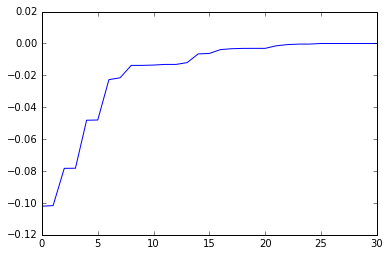

In [88]:
plt.plot(lr_pca[1:])

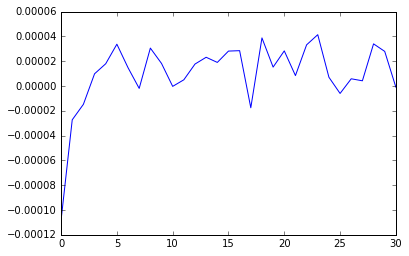

In [89]:
plt.plot(rf_pca[1:])

In [9]:
m = df_train['smiles'][0]

In [ ]:
### From the sample notebook:  

In [3]:
"""
Read in train and test as Pandas DataFrames
"""
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [6]:
#DataFrame with all train and test examples so we can more easily apply feature engineering on
df_all = pd.concat((df_train, df_test), axis=0)
df_all.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
#Drop the 'smiles' column
df_all = df_all.drop(['smiles'], axis=1)
vals = df_all.values
X_train = vals[:test_idx]
X_test = vals[test_idx:]
print "Train features:", X_train.shape
print "Train gap:", Y_train.shape
print "Test features:", X_test.shape

Train features: (1000000, 256)
Train gap: (1000000,)
Test features: (824230, 256)


In [48]:
write_to_file("sample1.csv", LR_pred)
write_to_file("sample2.csv", RF_pred)

In [5]:
#store gap values
Y_train = df_train.gap.values
#row where testing examples start
test_idx = df_train.shape[0]
#delete 'Id' column
df_test = df_test.drop(['Id'], axis=1)
#delete 'gap' column
df_train = df_train.drop(['gap'], axis=1)

In [12]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")